Ring Attractor
==============



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python

## Imports



In [1]:
import sys
sys.path.insert(0, '../../')

import torch
import gc
import pandas as pd
from time import perf_counter

from src.network import Network
from src.decode import decode_bump
from src.utils import clear_cache

REPO_ROOT = '/home/leon/models/NeuroTorch/'

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Parameters



In [1]:
conf_name = 'config_ringEI.yml'

## Single Trial



#### Model



In [1]:
start = perf_counter()

model = Network(conf_name, REPO_ROOT, TASK='odr_rand',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=1, LIVE_FF_UPDATE=1)

rates = model(RET_FF=1).cpu().numpy()

end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))

Ne = model.Na[0].detach().cpu().numpy()
N = model.N_NEURON

print('rates', rates.shape)

Elapsed (with compilation) = 0h 0m 6s
rates (1, 11, 500)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print('m0', m0.shape)

m0 (1, 11)

#### Dynamics



(1, 11, 500)

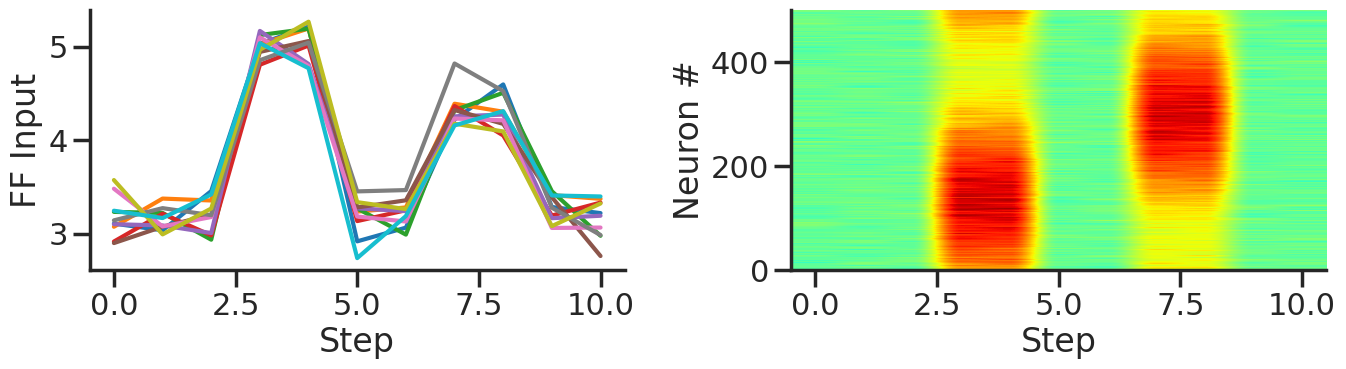

In [1]:
ff_input = model.ff_input.cpu().numpy()
print(ff_input.shape)

fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot(ff_input[0, :, :5])
ax[0].plot(ff_input[0, :, -5:])
ax[0].set_xlabel('Step')
ax[0].set_ylabel('FF Input')

ax[1].imshow(ff_input[0].T, cmap='jet', vmin=0, aspect='auto')
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Neuron #')
ax[1].set_ylim([0, Ne])
plt.show()

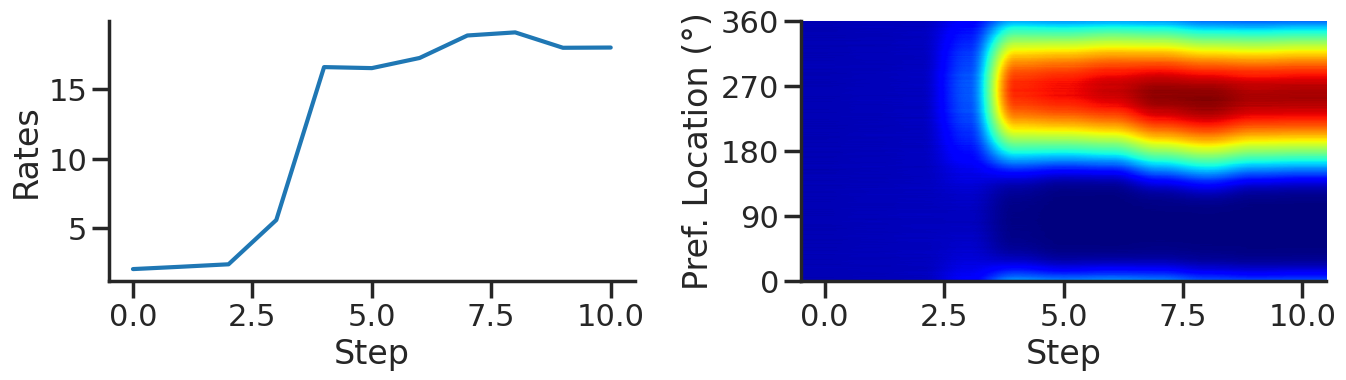

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

r_max = np.max(rates[0])

ax[0].plot(rates.mean(-1).T)
ax[0].set_ylabel('Rates')
ax[0].set_xlabel('Step')

ax[1].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max)
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
ax[1].set_yticks(np.linspace(0, Ne, 5), np.linspace(360, 0, 5).astype(int))
# ax[0][1].colorbar()

plt.show()

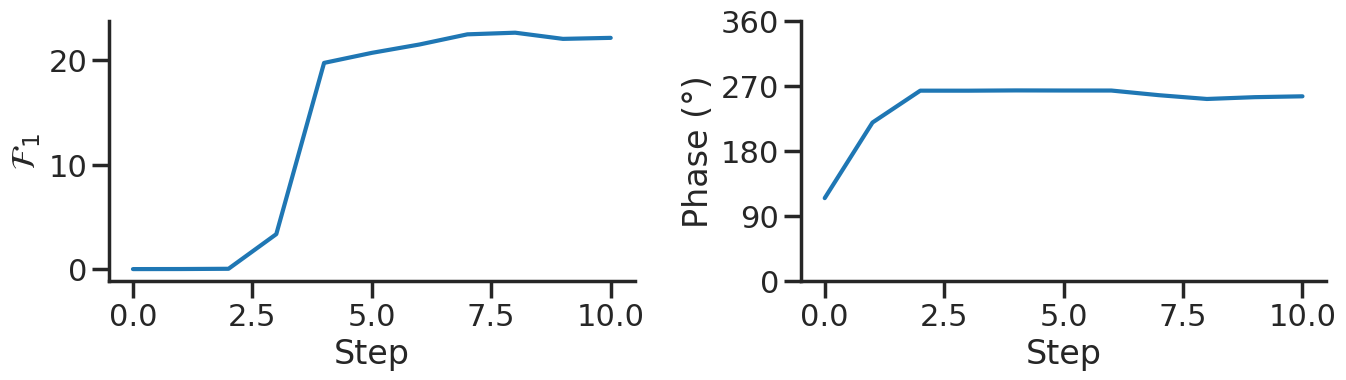

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

ax[0].plot((m1.T))
ax[0].set_xlabel('Step')
ax[0].set_ylabel('$\mathcal{F}_1$')

ax[1].plot((phi.T * 180 / np.pi))
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_xlabel('Step')
ax[1].set_ylabel('Phase (°)')
plt.show()

## Rates vs Jee



In [1]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, DT=0.001, VERBOSE=0, LIVE_FF_UPDATE=1)

In [1]:
N_BATCH = 10
model.J_STP = torch.linspace(0, 10, N_BATCH, dtype=torch.float32, device='cuda').unsqueeze(-1)

model.N_BATCH = N_BATCH
rates_Jee = model(RET_STP=1).cpu().detach().numpy()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(m0.shape)

(10, 21)

In [1]:
u_list = model.u_list.cpu().numpy()
x_list = model.x_list.cpu().numpy()
A_ux = u_list * x_list
print(u_list.shape, x_list.shape)

(10, 21, 500) (10, 21, 500)

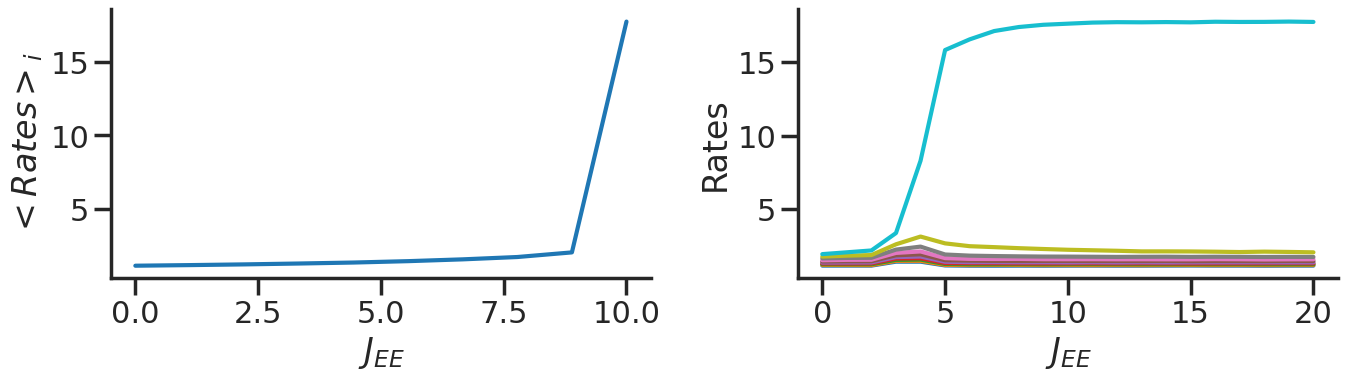

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = rates_Jee[:,-1].mean(-1)

ax[0].plot(model.J_STP.cpu(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$<Rates>_i$')

ax[1].plot(rates_Jee.mean(-1).T)
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('Rates')
plt.show()

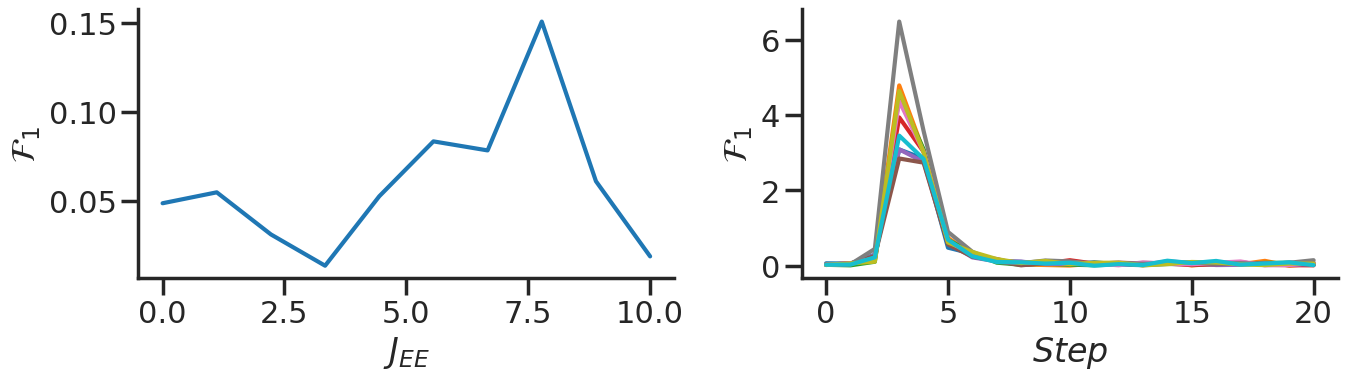

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(model.J_STP.cpu(), m1[:, -1])
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$\mathcal{F}_1$')

ax[1].plot(m1.T)
ax[1].set_xlabel('$Step$')
ax[1].set_ylabel('$\mathcal{F}_1$')
plt.show()

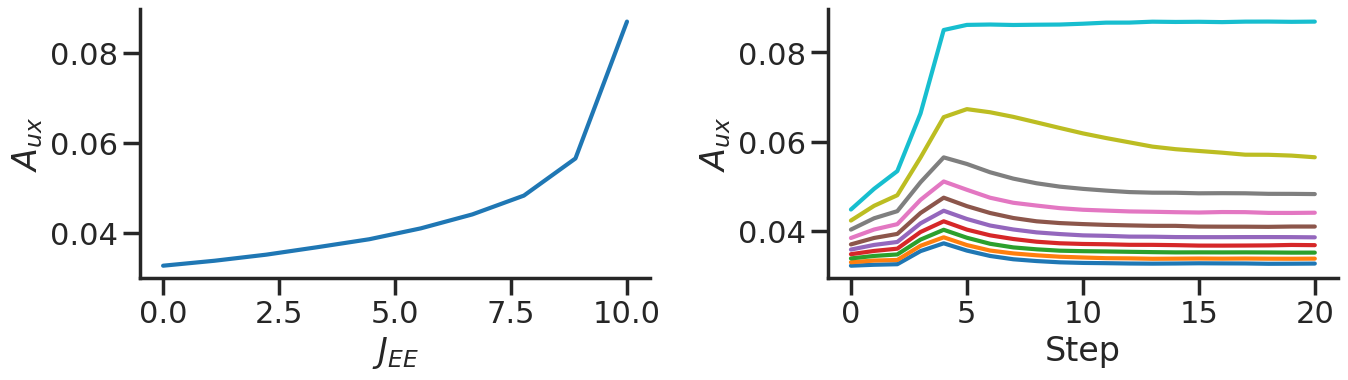

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

mean_rates = A_ux[:,-1].mean(-1) 

ax[0].plot(model.J_STP.cpu(), mean_rates)
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$A_{ux}$')

ax[1].plot(A_ux.mean(-1).T)
ax[1].set_xlabel('Step')
ax[1].set_ylabel('$A_{ux}$')

plt.show()

## Rates vs Jee vs Ie



In [1]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, DT=0.001, VERBOSE=0, LIVE_FF_UPDATE=1, N_BATCH=1)

In [1]:
N_BATCH = 20

J_STP = torch.linspace(5, 10, N_BATCH, device='cuda')
print(J_STP)
JE0 = torch.linspace(0, 10, N_BATCH, device='cuda')
print(JE0)

J_STP = J_STP.unsqueeze(0).expand(N_BATCH, N_BATCH)
print('J_STP', J_STP[1])
J_STP = J_STP.reshape((-1, 1)) # * model.Jab[0, 0]
# print(J_STP.shape)

JE0 = JE0.unsqueeze(1).expand(N_BATCH, N_BATCH)
print('JE0', JE0[1])
JE0 = JE0.reshape((-1, 1)) * model.M0
print(JE0.shape)

new_Ja0 = model.Ja0.repeat((N_BATCH * N_BATCH, 1, 1))
print(new_Ja0.shape)

new_Ja0[:,0] = JE0
# print(new_Ja0.shape)

#+begin_example
  tensor([ 5.0000,  5.2632,  5.5263,  5.7895,  6.0526,  6.3158,  6.5789,  6.8421,
           7.1053,  7.3684,  7.6316,  7.8947,  8.1579,  8.4211,  8.6842,  8.9474,
           9.2105,  9.4737,  9.7368, 10.0000], device='cuda:0')
  tensor([ 0.0000,  0.5263,  1.0526,  1.5789,  2.1053,  2.6316,  3.1579,  3.6842,
           4.2105,  4.7368,  5.2632,  5.7895,  6.3158,  6.8421,  7.3684,  7.8947,
           8.4211,  8.9474,  9.4737, 10.0000], device='cuda:0')
  J_STP tensor([ 5.0000,  5.2632,  5.5263,  5.7895,  6.0526,  6.3158,  6.5789,  6.8421,
           7.1053,  7.3684,  7.6316,  7.8947,  8.1579,  8.4211,  8.6842,  8.9474,
           9.2105,  9.4737,  9.7368, 10.0000], device='cuda:0')
  JE0 tensor([0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263,
          0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263, 0.5263,
          0.5263, 0.5263], device='cuda:0')
  torch.Size([400, 1])
  torch.Size([400, 2, 1])
#+end_example

In [1]:
model.N_BATCH = N_BATCH * N_BATCH
model.Ja0 = new_Ja0
model.J_STP = J_STP

start = perf_counter()
rates = model().cpu().detach().numpy()
end = perf_counter()
print("Elapsed (with compilation) = %dh %dm %ds" % convert_seconds(end - start))
print(rates.shape)

Elapsed (with compilation) = 0h 0m 11s
(400, 21, 500)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(m0.shape)

m0 = m0.reshape(N_BATCH, N_BATCH,-1)
m1 = m1.reshape(N_BATCH, N_BATCH,-1)

(400, 21)

In [1]:
J_STP = np.linspace(5, 10, N_BATCH)
print('Jee', J_STP)
JE0 = np.linspace(0, 10, N_BATCH)
print('Je0', JE0)

Jee [ 5.          5.26315789  5.52631579  5.78947368  6.05263158  6.31578947
  6.57894737  6.84210526  7.10526316  7.36842105  7.63157895  7.89473684
  8.15789474  8.42105263  8.68421053  8.94736842  9.21052632  9.47368421
  9.73684211 10.        ]
Je0 [ 0.          0.52631579  1.05263158  1.57894737  2.10526316  2.63157895
  3.15789474  3.68421053  4.21052632  4.73684211  5.26315789  5.78947368
  6.31578947  6.84210526  7.36842105  7.89473684  8.42105263  8.94736842
  9.47368421 10.        ]

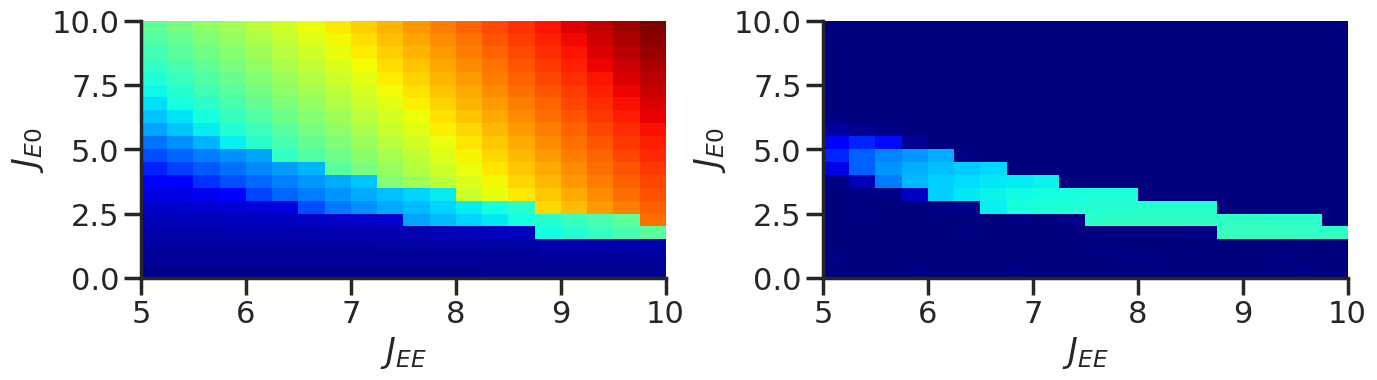

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].imshow(m0[..., -1], cmap='jet', origin='lower', vmin=0, aspect='auto', extent=[J_STP[0], J_STP[-1], JE0[0], JE0[-1]])
ax[0].set_xlabel('$J_{EE}$')
ax[0].set_ylabel('$J_{E0}$')

ax[1].imshow(m1[...,-1]/m0[...,-1], cmap='jet', origin='lower', vmin=0, vmax=3, aspect='auto', extent=[J_STP[0], J_STP[-1], JE0[0], JE0[-1]])
ax[1].set_xlabel('$J_{EE}$')
ax[1].set_ylabel('$J_{E0}$')

plt.show()

In [1]:
print(m1.shape)

In [1]:
J_STP = torch.linspace(5, 10, N_BATCH, device='cuda')
print(J_STP)
JE0 = torch.linspace(0, 10, N_BATCH, device='cuda')
print(JE0)

J_STP = J_STP.unsqueeze(0).expand(N_BATCH, N_BATCH)
JE0 = JE0.unsqueeze(1).expand(N_BATCH, N_BATCH)

print('JE0', JE0[3, -1])
print('J_STP', J_STP[3, -1])

tensor([ 5.0000,  5.2632,  5.5263,  5.7895,  6.0526,  6.3158,  6.5789,  6.8421,
         7.1053,  7.3684,  7.6316,  7.8947,  8.1579,  8.4211,  8.6842,  8.9474,
         9.2105,  9.4737,  9.7368, 10.0000], device='cuda:0')
tensor([ 0.0000,  0.5263,  1.0526,  1.5789,  2.1053,  2.6316,  3.1579,  3.6842,
         4.2105,  4.7368,  5.2632,  5.7895,  6.3158,  6.8421,  7.3684,  7.8947,
         8.4211,  8.9474,  9.4737, 10.0000], device='cuda:0')
JE0 tensor(1.5789, device='cuda:0')
J_STP tensor(10., device='cuda:0')

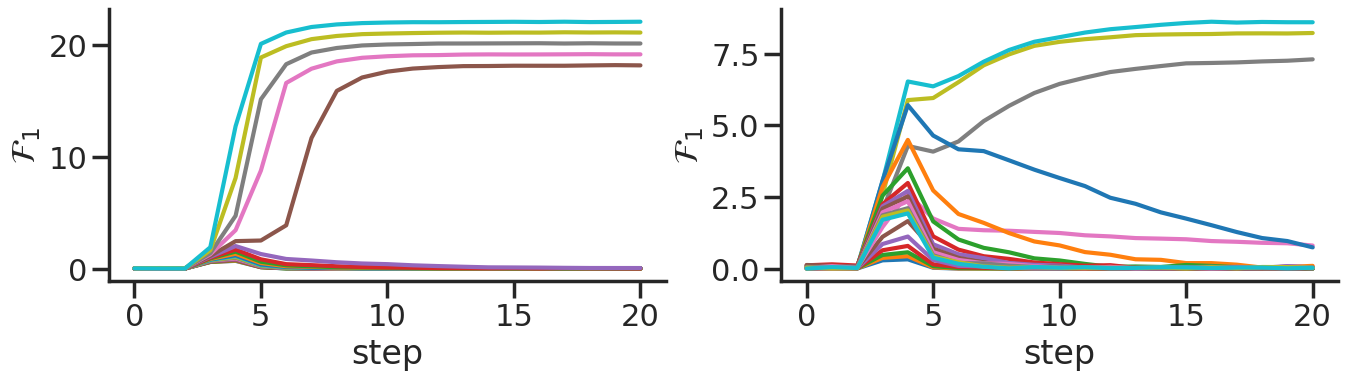

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])

ax[0].plot(m1[3].T)
ax[0].set_ylabel('$\mathcal{F}_1$')
ax[0].set_xlabel('step')

ax[1].plot(m1[:, 3].T)
ax[1].set_ylabel('$\mathcal{F}_1$')
ax[1].set_xlabel('step')

plt.show()

## Test



In [1]:
JE0 = torch.linspace(0, 10, N_BATCH, device='cuda')
print(JE0[3])
J_STP = torch.linspace(5, 10, N_BATCH, device='cuda')
print(J_STP[-1])

tensor(1.5789, device='cuda:0')
tensor(10., device='cuda:0')

In [1]:
model = Network(conf_name, REPO_ROOT, TASK='odr_rand',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=10, LIVE_FF_UPDATE=1)

model.Ja0[:, 0] = JE0[3] * model.M0
model.J_STP = J_STP[-1]

In [1]:
rates = model().cpu().numpy()

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print('m0', m0.shape)

m0 (10, 21)

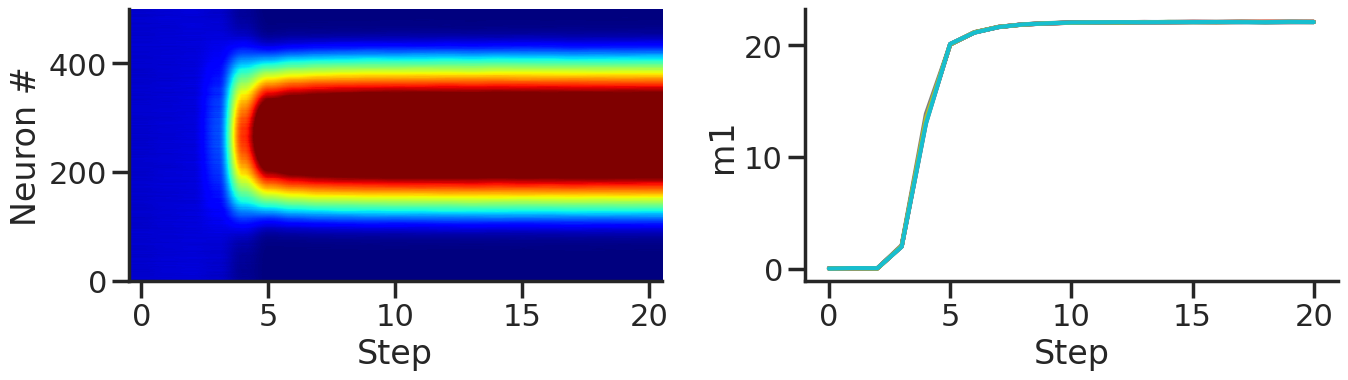

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))

r_max = 30

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Neuron #')
ax[0].set_xlabel('Step')

ax[1].plot(m1.T)
ax[1].set_ylabel('m1')
ax[1].set_xlabel('Step')

plt.show()

## Serial bias



In [1]:
model = Network(conf_name, REPO_ROOT, TASK='odr',
                VERBOSE=0, DEVICE='cuda', seed=0, N_BATCH=1, LIVE_FF_UPDATE=1)

In [1]:
N_PHASE = 512
print(model.PHI0.shape)

PHI0 = model.PHI0.unsqueeze(-1).repeat((N_PHASE, 1, 1))

print(PHI0.shape)
PHI0[:, -1] = torch.randint(0, 360, (N_PHASE,), device=model.device).unsqueeze(1)
PHI0[:, 0] = torch.randint(0, 360, (N_PHASE,)).unsqueeze(1)

In [1]:
model.PHI0 = PHI0
model.N_BATCH = N_PHASE
rates = model().cpu().numpy()
print(rates.shape)

(512, 11, 500)

In [1]:
m0, m1, phi = decode_bump(rates, axis=-1)
print(phi.shape)

(512, 11)

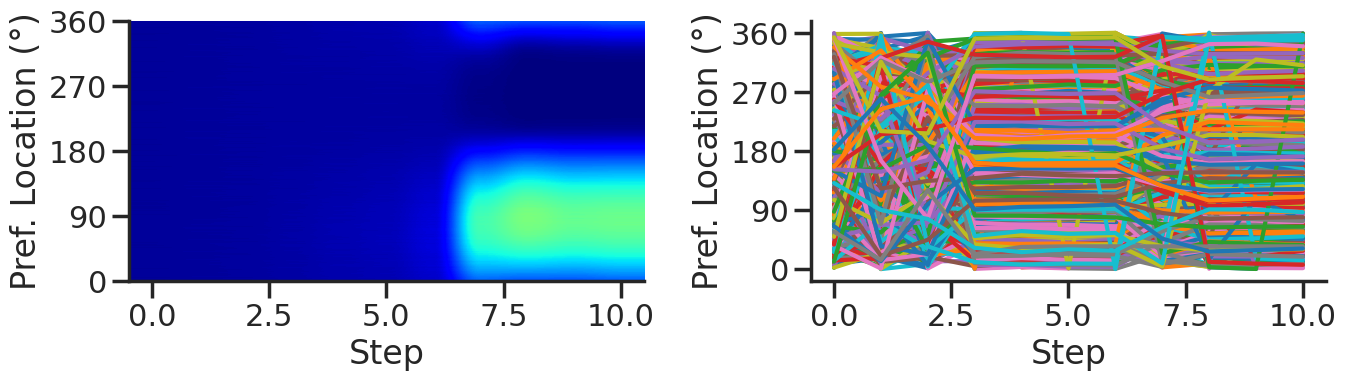

In [1]:
fig, ax = plt.subplots(1, 2, figsize=[2*width, height])
r_max = np.max(rates[0]) *2

ax[0].imshow(rates[0].T, aspect='auto', cmap='jet', vmin=0, vmax=r_max, origin='lower')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))
ax[0].set_xlabel('Step')

ax[1].plot(phi.T * 180 / np.pi)
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int), np.linspace(0, 360, 5).astype(int))
ax[1].set_ylabel('Pref. Location (°)')
ax[1].set_xlabel('Step')
plt.show()

In [1]:
target_loc = model.PHI0[:, -1].cpu().numpy()
rel_loc = model.PHI0[:, 0].cpu().numpy() - target_loc
rel_loc = (rel_loc/180*np.pi + np.pi) % (2*np.pi) - np.pi
errors = phi - target_loc*np.pi/180.
errors = (errors + np.pi) % (2*np.pi) - np.pi

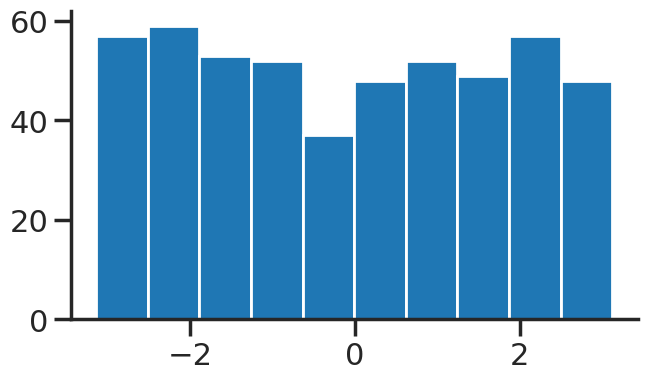

In [1]:
plt.hist(rel_loc);

    plt.hist(errors[:, -1], bins='auto')
    plt.show()



#### Systematic biases



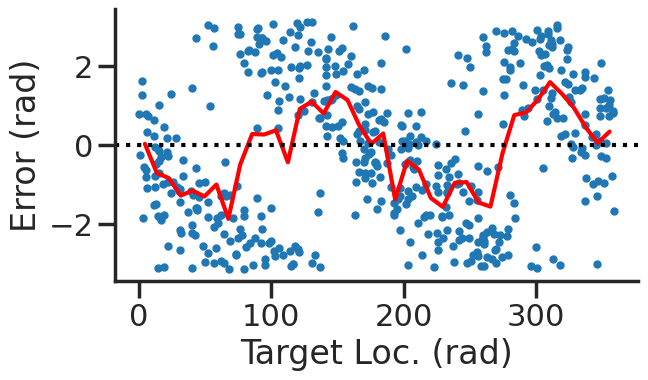

In [1]:
plt.plot(target_loc[:, 0], errors[:,-1], 'o')
plt.xlabel('Target Loc. (rad)')
plt.ylabel('Error (rad)')
#plt.ylim([-60, 60])

from scipy.stats import binned_statistic
stt = binned_statistic(target_loc[:,0], errors[:,-1], statistic='mean', bins=40, range=[0, 360])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")

#### Serial biases



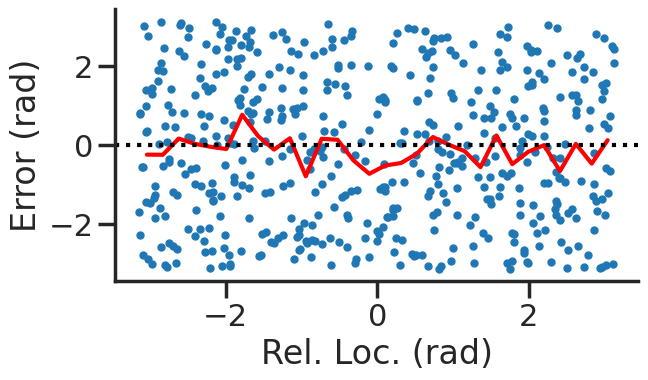

In [1]:
plt.plot(rel_loc[:, 0], errors[:,-1], 'o')
plt.xlabel('Rel. Loc. (rad)')
plt.ylabel('Error (rad)')
#plt.ylim([-60, 60])

from scipy.stats import binned_statistic
stt = binned_statistic(rel_loc[:,0], errors[:,-1], statistic='mean', bins=30, range=[-np.pi, np.pi])
dstt = np.mean(np.diff(stt.bin_edges))
plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic,'r')

plt.axhline(color='k', linestyle=":")
plt.show()